In [5]:
%ls ../../mickey

benchmark/  data/              lib/     README.md   submission.py  weights/
config/     demo_inference.py  LICENSE  resources/  train.py


In [1]:
import sys
import os

sys.path.append(
    '..'
)

from pathlib import Path
from collections import defaultdict
from dataclasses import dataclass
from zipfile import ZipFile

import torch
import numpy as np
from tqdm import tqdm

from config.default import cfg
from lib.datasets.datamodules import DataModule
from lib.models.builder import build_model
from lib.utils.data import data_to_model_device
from transforms3d.quaternions import mat2quat

from pathlib import Path
from io import TextIOWrapper
import json
import logging
import matplotlib.pyplot as plt
import numpy as np

from benchmark.utils import load_poses, subsample_poses, load_K, precision_recall
from benchmark.metrics import MetricManager, Inputs
import benchmark.config as config
from config.default import cfg

import matplotlib
import matplotlib.image as mpimg

from lib.eval.silk_runner import SilkRunner

/home/vgmachinist/anaconda3/envs/silk/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'lib.datasets'

Current Idea:
Loop through validation set and output the difference in distance and rotation from the ground truth

Info:
- `intrinsics.txt` encodes per frame intrinsics with the following format
    - `frame_path fx fy cx cy frame_width frame_height`
- `poses.txt` encodes per frame extrinsics with the following format:
    - `frame_path qw qx qy qz tx ty tz` where `q` is the quaternion encoding rotation

First get results from running on dataset

In [2]:
# set type of dataset split, checkpoint path, config path
dataset_split = 'val'
checkpoint = '../../mickey/weights/mickey.ckpt'
config = '../../mickey/config/MicKey/curriculum_learning.yaml'
output_root = Path('..', 'results')

cfg.merge_from_file('../../mickey/config/datasets/mapfree.yaml')
cfg.merge_from_file(config)

cfg.DATASET.DATA_ROOT = "../../mickey/data"

# Create dataloader
if dataset_split == 'test':
    cfg.TRAINING.BATCH_SIZE = 8
    cfg.TRAINING.NUM_WORKERS = 8
    dataloader = DataModule(cfg, drop_last_val=False).test_dataloader()
elif dataset_split == 'val':
    cfg.TRAINING.BATCH_SIZE = 16
    cfg.TRAINING.NUM_WORKERS = 8
    dataloader = DataModule(cfg, drop_last_val=False).val_dataloader()
else:
    raise NotImplemented(f'Invalid split: {dataset_split}')

# Create model
model = build_model(cfg, checkpoint)

In [ ]:
results_dict = defaultdict(list)
i = 0
for data in tqdm(dataloader):
    data = data_to_model_device(data, model)
    print(data)
    with torch.no_grad():
        R_batched, t_batched = model(data)
        
    for i_batch in range(len(data['scene_id'])):
        # corr_dir_elems = [cfg.DATASET.DATA_ROOT, dataset_split, data['scene_id'][i_batch], data['pair_names'][1][i_batch]]
        # corr_save_path = os.path.join(*corr_dir_elems)
        # corr_save_path = os.path.splitext(corr_save_path)[0] + ".txt"
        # corr_save_path = corr_save_path.replace(os.sep + "seq1" + os.sep, os.sep + "corr" + os.sep)
        # corr_dir_path = os.path.split(corr_save_path)[0]
        # if not os.path.exists(corr_dir_path):
        #     os.mkdir(os.path.split(corr_save_path)[0])
        
        refer_fname = data['pair_names'][0][i_batch]
        query_fname = data['pair_names'][1][i_batch]
        R = R_batched[i_batch].unsqueeze(0).detach().cpu().numpy()
        t = t_batched[i_batch].reshape(-1).detach().cpu().numpy()
        inliers = data['inliers'][i_batch].item()
        break

    #     np.savetxt(corr_save_path, data['inliers_list'][i_batch].detach().cpu())
        
    #     scene = data['scene_id'][i_batch]
    #     query_img = data['pair_names'][1][i_batch]
        
    #     # ignore frames without poses (e.g. not enough feature matches)
    #     if np.isnan(R).any() or np.isnan(t).any() or np.isinf(t).any():
    #         continue

    #     # populate results_dict
    #     estimated_pose = Pose(image_name=query_img,
    #                           q=mat2quat(R).reshape(-1),
    #                           t=t.reshape(-1),
    #                           inliers=inliers)
    #     results_dict[scene].append(estimated_pose)
        

  0%|                                                                                                                                                                                                                                 | 0/463 [00:00<?, ?it/s]

{'image0': tensor([[[[0.7451, 0.8078, 0.6549,  ..., 0.2471, 0.1725, 0.1569],
          [0.8078, 0.6627, 0.6627,  ..., 0.4314, 0.3843, 0.4510],
          [0.8039, 0.6706, 0.6353,  ..., 0.3059, 0.3255, 0.2941],
          ...,
          [0.7686, 0.9922, 0.8314,  ..., 0.7137, 0.5451, 0.6667],
          [0.7529, 0.7686, 0.7020,  ..., 0.3804, 0.4863, 0.5137],
          [1.0000, 1.0000, 0.8902,  ..., 0.3373, 0.4118, 0.5294]],

         [[0.6941, 0.7608, 0.6078,  ..., 0.2588, 0.1922, 0.1843],
          [0.7529, 0.6157, 0.6235,  ..., 0.4235, 0.3804, 0.4471],
          [0.7490, 0.6196, 0.5922,  ..., 0.2431, 0.2706, 0.2392],
          ...,
          [0.7098, 0.9333, 0.7725,  ..., 0.7843, 0.6157, 0.7373],
          [0.6941, 0.7098, 0.6431,  ..., 0.4510, 0.5608, 0.5882],
          [0.9412, 0.9451, 0.8314,  ..., 0.4078, 0.4863, 0.6039]],

         [[0.5294, 0.6039, 0.4588,  ..., 0.3176, 0.2667, 0.2549],
          [0.6000, 0.4667, 0.4824,  ..., 0.4784, 0.4431, 0.5098],
          [0.6118, 0.4863, 0.46

  0%|▍                                                                                                                                                                                                                        | 1/463 [00:06<46:30,  6.04s/it]

{'image0': tensor([[[[0.7451, 0.8078, 0.6549,  ..., 0.2471, 0.1725, 0.1569],
          [0.8078, 0.6627, 0.6627,  ..., 0.4314, 0.3843, 0.4510],
          [0.8039, 0.6706, 0.6353,  ..., 0.3059, 0.3255, 0.2941],
          ...,
          [0.7686, 0.9922, 0.8314,  ..., 0.7137, 0.5451, 0.6667],
          [0.7529, 0.7686, 0.7020,  ..., 0.3804, 0.4863, 0.5137],
          [1.0000, 1.0000, 0.8902,  ..., 0.3373, 0.4118, 0.5294]],

         [[0.6941, 0.7608, 0.6078,  ..., 0.2588, 0.1922, 0.1843],
          [0.7529, 0.6157, 0.6235,  ..., 0.4235, 0.3804, 0.4471],
          [0.7490, 0.6196, 0.5922,  ..., 0.2431, 0.2706, 0.2392],
          ...,
          [0.7098, 0.9333, 0.7725,  ..., 0.7843, 0.6157, 0.7373],
          [0.6941, 0.7098, 0.6431,  ..., 0.4510, 0.5608, 0.5882],
          [0.9412, 0.9451, 0.8314,  ..., 0.4078, 0.4863, 0.6039]],

         [[0.5294, 0.6039, 0.4588,  ..., 0.3176, 0.2667, 0.2549],
          [0.6000, 0.4667, 0.4824,  ..., 0.4784, 0.4431, 0.5098],
          [0.6118, 0.4863, 0.46

  0%|▉                                                                                                                                                                                                                        | 2/463 [00:09<33:38,  4.38s/it]

{'image0': tensor([[[[0.7451, 0.8078, 0.6549,  ..., 0.2471, 0.1725, 0.1569],
          [0.8078, 0.6627, 0.6627,  ..., 0.4314, 0.3843, 0.4510],
          [0.8039, 0.6706, 0.6353,  ..., 0.3059, 0.3255, 0.2941],
          ...,
          [0.7686, 0.9922, 0.8314,  ..., 0.7137, 0.5451, 0.6667],
          [0.7529, 0.7686, 0.7020,  ..., 0.3804, 0.4863, 0.5137],
          [1.0000, 1.0000, 0.8902,  ..., 0.3373, 0.4118, 0.5294]],

         [[0.6941, 0.7608, 0.6078,  ..., 0.2588, 0.1922, 0.1843],
          [0.7529, 0.6157, 0.6235,  ..., 0.4235, 0.3804, 0.4471],
          [0.7490, 0.6196, 0.5922,  ..., 0.2431, 0.2706, 0.2392],
          ...,
          [0.7098, 0.9333, 0.7725,  ..., 0.7843, 0.6157, 0.7373],
          [0.6941, 0.7098, 0.6431,  ..., 0.4510, 0.5608, 0.5882],
          [0.9412, 0.9451, 0.8314,  ..., 0.4078, 0.4863, 0.6039]],

         [[0.5294, 0.6039, 0.4588,  ..., 0.3176, 0.2667, 0.2549],
          [0.6000, 0.4667, 0.4824,  ..., 0.4784, 0.4431, 0.5098],
          [0.6118, 0.4863, 0.46

  1%|█▍                                                                                                                                                                                                                       | 3/463 [00:12<28:17,  3.69s/it]

{'image0': tensor([[[[0.7451, 0.8078, 0.6549,  ..., 0.2471, 0.1725, 0.1569],
          [0.8078, 0.6627, 0.6627,  ..., 0.4314, 0.3843, 0.4510],
          [0.8039, 0.6706, 0.6353,  ..., 0.3059, 0.3255, 0.2941],
          ...,
          [0.7686, 0.9922, 0.8314,  ..., 0.7137, 0.5451, 0.6667],
          [0.7529, 0.7686, 0.7020,  ..., 0.3804, 0.4863, 0.5137],
          [1.0000, 1.0000, 0.8902,  ..., 0.3373, 0.4118, 0.5294]],

         [[0.6941, 0.7608, 0.6078,  ..., 0.2588, 0.1922, 0.1843],
          [0.7529, 0.6157, 0.6235,  ..., 0.4235, 0.3804, 0.4471],
          [0.7490, 0.6196, 0.5922,  ..., 0.2431, 0.2706, 0.2392],
          ...,
          [0.7098, 0.9333, 0.7725,  ..., 0.7843, 0.6157, 0.7373],
          [0.6941, 0.7098, 0.6431,  ..., 0.4510, 0.5608, 0.5882],
          [0.9412, 0.9451, 0.8314,  ..., 0.4078, 0.4863, 0.6039]],

         [[0.5294, 0.6039, 0.4588,  ..., 0.3176, 0.2667, 0.2549],
          [0.6000, 0.4667, 0.4824,  ..., 0.4784, 0.4431, 0.5098],
          [0.6118, 0.4863, 0.46

  1%|█▊                                                                                                                                                                                                                       | 4/463 [00:15<26:27,  3.46s/it]

{'image0': tensor([[[[0.7451, 0.8078, 0.6549,  ..., 0.2471, 0.1725, 0.1569],
          [0.8078, 0.6627, 0.6627,  ..., 0.4314, 0.3843, 0.4510],
          [0.8039, 0.6706, 0.6353,  ..., 0.3059, 0.3255, 0.2941],
          ...,
          [0.7686, 0.9922, 0.8314,  ..., 0.7137, 0.5451, 0.6667],
          [0.7529, 0.7686, 0.7020,  ..., 0.3804, 0.4863, 0.5137],
          [1.0000, 1.0000, 0.8902,  ..., 0.3373, 0.4118, 0.5294]],

         [[0.6941, 0.7608, 0.6078,  ..., 0.2588, 0.1922, 0.1843],
          [0.7529, 0.6157, 0.6235,  ..., 0.4235, 0.3804, 0.4471],
          [0.7490, 0.6196, 0.5922,  ..., 0.2431, 0.2706, 0.2392],
          ...,
          [0.7098, 0.9333, 0.7725,  ..., 0.7843, 0.6157, 0.7373],
          [0.6941, 0.7098, 0.6431,  ..., 0.4510, 0.5608, 0.5882],
          [0.9412, 0.9451, 0.8314,  ..., 0.4078, 0.4863, 0.6039]],

         [[0.5294, 0.6039, 0.4588,  ..., 0.3176, 0.2667, 0.2549],
          [0.6000, 0.4667, 0.4824,  ..., 0.4784, 0.4431, 0.5098],
          [0.6118, 0.4863, 0.46

In [8]:
R

dict_keys(['image0', 'image1', 'T_0to1', 'abs_q_0', 'abs_c_0', 'abs_q_1', 'abs_c_1', 'K_color0', 'Kori_color0', 'K_color1', 'Kori_color1', 'dataset_name', 'scene_id', 'scene_root', 'pair_id', 'pair_names', 'kps0_shape', 'kps1_shape', 'depth0_map', 'depth1_map', 'down_factor', 'kps0', 'depth_kp0', 'scr0', 'kps1', 'depth_kp1', 'scr1', 'scores', 'dsc0', 'dsc1', 'kp_scores', 'final_scores'])

In [18]:
def data_to_cpu(data: dict):
    for k, v in data.items():
        if torch.is_tensor(v):
            data[k] = v.detach().cpu()
        if k == 'inliers_list':
            data[k] = [i.detach().cpu() for i in data[k]]
data_to_cpu(data)      

In [21]:
data['image0'].shape

torch.Size([16, 3, 720, 540])

In [8]:
for k, v in data.items():
    print(k)
    print(type(v))

image0
<class 'torch.Tensor'>
image1
<class 'torch.Tensor'>
T_0to1
<class 'torch.Tensor'>
abs_q_0
<class 'torch.Tensor'>
abs_c_0
<class 'torch.Tensor'>
abs_q_1
<class 'torch.Tensor'>
abs_c_1
<class 'torch.Tensor'>
K_color0
<class 'torch.Tensor'>
Kori_color0
<class 'torch.Tensor'>
K_color1
<class 'torch.Tensor'>
Kori_color1
<class 'torch.Tensor'>
dataset_name
<class 'list'>
scene_id
<class 'list'>
scene_root
<class 'list'>
pair_id
<class 'torch.Tensor'>
pair_names
<class 'list'>
kps0_shape
<class 'list'>
kps1_shape
<class 'list'>
depth0_map
<class 'torch.Tensor'>
depth1_map
<class 'torch.Tensor'>
down_factor
<class 'int'>
kps0
<class 'torch.Tensor'>
depth_kp0
<class 'torch.Tensor'>
scr0
<class 'torch.Tensor'>
kps1
<class 'torch.Tensor'>
depth_kp1
<class 'torch.Tensor'>
scr1
<class 'torch.Tensor'>
scores
<class 'torch.Tensor'>
dsc0
<class 'torch.Tensor'>
dsc1
<class 'torch.Tensor'>
kp_scores
<class 'torch.Tensor'>
final_scores
<class 'torch.Tensor'>
R
<class 'torch.Tensor'>
t
<class 'tor

In [31]:
# Get predictions from model and save in submission.zip
results_dict = predict(dataloader, model)
output_root.mkdir(parents=True, exist_ok=True)
save_submission(results_dict, output_root / 'submission.zip')

  0%|▉                                                                                                                                                                                                                               | 2/463 [00:08<31:42,  4.13s/it]


KeyboardInterrupt: 

Now calculate metrics from results. Just grab information from submission.zip

In [ ]:
def plot_images_correspondences(axis, x, y, color, img, title):
    axis.imshow(mpimg.imread(img))
    axis.scatter(x, y, color=color, s=1)
    axis.set_title(title)

def populate_results_with_imgs(results_with_imgs, query_img_path, metrics):
    for k in metrics:
        results_with_imgs[k].append((str(query_img_path), metrics[k]))
        

dataset_path = Path("..", "data/") / dataset_split
scenes = tuple(f.name for f in dataset_path.iterdir() if f.is_dir())
submission_zip = ZipFile(output_root / 'submission.zip', 'r')
all_results = dict()
all_failures = 0
results_with_imgs = defaultdict(list)
print(f'number of scenes: {len(scenes)}')
num_correspondences = 0
for scene in scenes:
    scene_path = dataset_path / scene
    print(f'scene path: {scene_path}')
    # load both images as well as the correspondences file for both images
    # plot both images and draw the correspondences
    # save plot in the same place
    # have a dictionary containing ordered lists based on the error
    
    
    metrics, failures = compute_scene_metrics(
        dataset_path, submission_zip, scene)
    # all_results[scene] = metrics
    # all_failures += failures
    
    ref_img_path = scene_path / 'seq0' / 'frame_00000.jpg'
    query_imgs_path = scene_path / 'seq1'
    num_imgs = len(os.listdir(query_imgs_path)) // 5 # in validation they take every 5th frame

    print(f'compare: {num_imgs} {len(metrics["trans_err"])}')
    
    # assert num_imgs == len(metrics['trans_err'])
    i = 0
    while i < len(metrics["trans_err"]):
        j = i
        while j < len(metrics["trans_err"]):
            query_img_fname = f'frame_{str(j).zfill(5)}.jpg'
            query_img_path = query_imgs_path / query_img_fname
            corr_path = os.path.splitext(query_img_path)[0] + '.txt'
            corr_path = corr_path.replace(os.sep + "seq1" + os.sep, os.sep + "corr" + os.sep)
            if os.path.exists(corr_path):
                break
            j += 1

        i = j
        if i >= len(metrics["trans_err"]):
            break
        populate_results_with_imgs(results_with_imgs, query_img_path, {k : metrics[k][i] for k in metrics})
        fig_path = corr_path.replace(os.sep + "corr" + os.sep, os.sep + "figs" + os.sep)
        fig_path = os.path.splitext(fig_path)[0] + ".jpg"
        
        img_pts = np.loadtxt(corr_path)
        num_correspondences += img_pts.shape[0]
        print(f'shape of img_pts: {img_pts.shape}')
        
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))
        plot_images_correspondences(axes[0], img_pts[:, 0], img_pts[:, 1], "red", str(ref_img_path), "Reference Image")
        plot_images_correspondences(axes[1], img_pts[:, 2], img_pts[:, 3], "blue", str(query_img_path), "Query Image")
        for n in range(img_pts.shape[0]):
            if i % 10 == 0:
                con = matplotlib.patches.ConnectionPatch(xyA=img_pts[n, :2], xyB=img_pts[n, 2:4], coordsA="data", coordsB="data",
                                          axesA=axes[0], axesB=axes[1], color="green")
                axes[1].add_artist(con)
        img_pts = None
        
        if not os.path.exists(os.path.split(fig_path)[0]):
            os.mkdir(os.path.split(fig_path)[0])
        print(f'saving figure {fig_path}')
        out = fig.savefig(fig_path)
        plt.close(out)
        del img_pts, fig, axes, out
        i += 1
        
        
        
    

number of scenes: 65
scene path: ../data/val/s00500
compare: 116 116
shape of img_pts: (200, 7)
saving figure ../data/val/s00500/figs/frame_00000.jpg
shape of img_pts: (172, 7)
saving figure ../data/val/s00500/figs/frame_00005.jpg
shape of img_pts: (154, 7)
saving figure ../data/val/s00500/figs/frame_00010.jpg
shape of img_pts: (234, 7)
saving figure ../data/val/s00500/figs/frame_00015.jpg
shape of img_pts: (206, 7)
saving figure ../data/val/s00500/figs/frame_00020.jpg
shape of img_pts: (237, 7)
saving figure ../data/val/s00500/figs/frame_00025.jpg
shape of img_pts: (220, 7)
saving figure ../data/val/s00500/figs/frame_00030.jpg
shape of img_pts: (160, 7)
saving figure ../data/val/s00500/figs/frame_00035.jpg
shape of img_pts: (139, 7)
saving figure ../data/val/s00500/figs/frame_00040.jpg
shape of img_pts: (195, 7)
saving figure ../data/val/s00500/figs/frame_00045.jpg
shape of img_pts: (270, 7)
saving figure ../data/val/s00500/figs/frame_00050.jpg
shape of img_pts: (201, 7)
saving figure

In [4]:
print(num_correspondences)

621835


In [4]:
with open("results.json", "w") as outfile: 
    json.dump(results_with_imgs, outfile)

In [17]:
median_metrics = defaultdict(list)
all_metrics = defaultdict(list)
for scene_results in all_results.values():
    for metric, values in scene_results.items():
        median_metrics[metric].append(np.median(values))
        all_metrics[metric].extend(values)
all_metrics = {k: np.array(v) for k, v in all_metrics.items()}

In [40]:
np.average(median_metrics['trans_err'])

1.9072412347977894

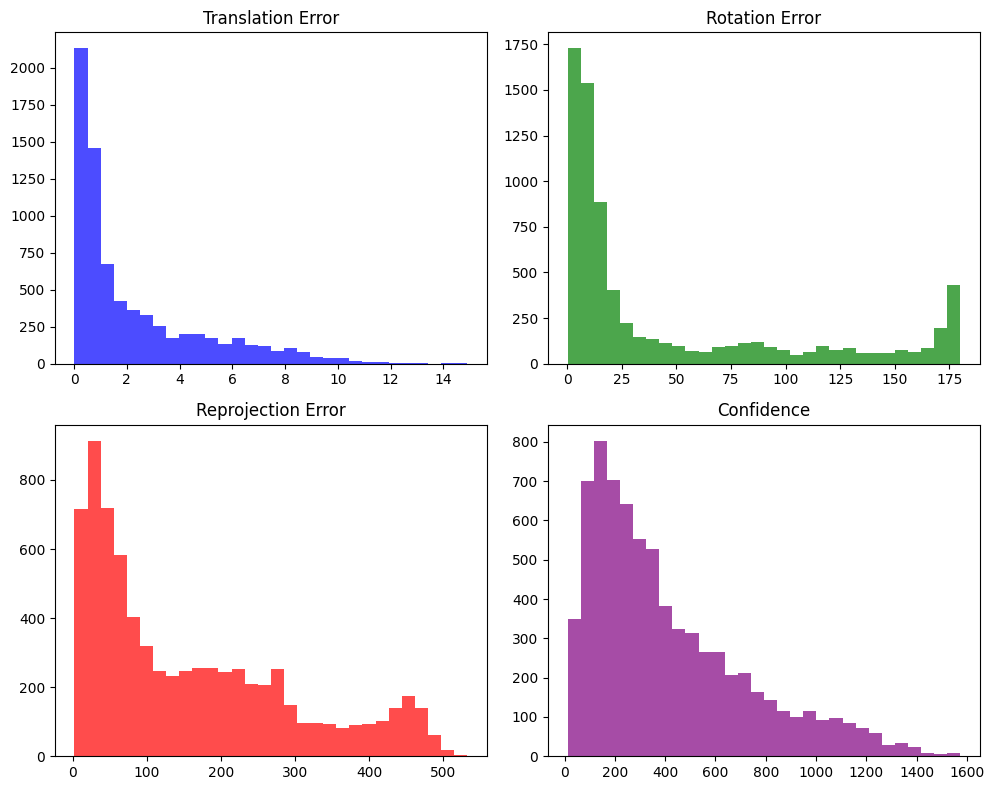

In [33]:
trans_err = all_metrics['trans_err']
rot_err = all_metrics['rot_err']
reproj_err = all_metrics['reproj_err']
conf = all_metrics['confidence']
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].hist(trans_err, bins=30, alpha=0.7, color='blue')
axs[0, 0].set_title('Translation Error')

axs[0, 1].hist(rot_err, bins=30, alpha=0.7, color='green')
axs[0, 1].set_title('Rotation Error')

axs[1, 0].hist(reproj_err, bins=30, alpha=0.7, color='red')
axs[1, 0].set_title('Reprojection Error')

axs[1, 1].hist(conf, bins=30, alpha=0.7, color='purple')
axs[1, 1].set_title('Confidence')

plt.tight_layout()
plt.show()

In [6]:
with open("results.json", "r") as f:
    data = json.load(f)

In [24]:
best_trans_err = sorted(data['trans_err'], key=lambda x: x[1])
best_trans_err[:10]

[['../data/val/s00523/seq1/frame_00040.jpg', 0.016985589500003843],
 ['../data/val/s00506/seq1/frame_00005.jpg', 0.035296205563300286],
 ['../data/val/s00478/seq1/frame_00095.jpg', 0.0369399291071285],
 ['../data/val/s00483/seq1/frame_00080.jpg', 0.037985454964916905],
 ['../data/val/s00475/seq1/frame_00085.jpg', 0.04544064999988911],
 ['../data/val/s00475/seq1/frame_00095.jpg', 0.045808025797652745],
 ['../data/val/s00523/seq1/frame_00060.jpg', 0.04848322364962348],
 ['../data/val/s00475/seq1/frame_00090.jpg', 0.05127424325727206],
 ['../data/val/s00486/seq1/frame_00090.jpg', 0.05136244981221082],
 ['../data/val/s00523/seq1/frame_00055.jpg', 0.0518103544813915]]

In [23]:
best_trans_err[-10:]

[['../data/val/s00461/seq1/frame_00100.jpg', 11.117327362153574],
 ['../data/val/s00461/seq1/frame_00105.jpg', 11.236044460082935],
 ['../data/val/s00461/seq1/frame_00110.jpg', 11.384439451224472],
 ['../data/val/s00520/seq1/frame_00005.jpg', 11.478693357620353],
 ['../data/val/s00523/seq1/frame_00000.jpg', 12.518416064212312],
 ['../data/val/s00509/seq1/frame_00000.jpg', 12.862570863337625],
 ['../data/val/s00509/seq1/frame_00005.jpg', 12.906464126105117],
 ['../data/val/s00480/seq1/frame_00000.jpg', 12.950781810675808],
 ['../data/val/s00507/seq1/frame_00000.jpg', 14.313291239293541],
 ['../data/val/s00481/seq1/frame_00005.jpg', 14.480995132703855]]

In [18]:
best_rot_err = sorted(data['rot_err'], key=lambda x: x[1])
best_rot_err[:10]

[['../data/val/s00498/seq1/frame_00010.jpg', 0.4645634681346907],
 ['../data/val/s00483/seq1/frame_00070.jpg', 0.5456485365658197],
 ['../data/val/s00475/seq1/frame_00085.jpg', 0.6070810670580539],
 ['../data/val/s00483/seq1/frame_00080.jpg', 0.6242962669805067],
 ['../data/val/s00498/seq1/frame_00005.jpg', 0.6784917139360027],
 ['../data/val/s00507/seq1/frame_00115.jpg', 0.7092524296283645],
 ['../data/val/s00488/seq1/frame_00090.jpg', 0.9758054062320585],
 ['../data/val/s00507/seq1/frame_00035.jpg', 0.9936713284244825],
 ['../data/val/s00511/seq1/frame_00025.jpg', 1.0353922374144984],
 ['../data/val/s00523/seq1/frame_00050.jpg', 1.1061123606649141]]

In [25]:
best_rot_err[-10:]

[['../data/val/s00497/seq1/frame_00095.jpg', 179.5665963663017],
 ['../data/val/s00465/seq1/frame_00100.jpg', 179.63264387800754],
 ['../data/val/s00465/seq1/frame_00090.jpg', 179.71009104548642],
 ['../data/val/s00476/seq1/frame_00095.jpg', 179.7264137597988],
 ['../data/val/s00505/seq1/frame_00115.jpg', 179.75540647764922],
 ['../data/val/s00497/seq1/frame_00105.jpg', 179.77288880007526],
 ['../data/val/s00497/seq1/frame_00080.jpg', 179.78881221711208],
 ['../data/val/s00497/seq1/frame_00075.jpg', 179.81600195592623],
 ['../data/val/s00497/seq1/frame_00090.jpg', 179.95355085709716],
 ['../data/val/s00505/seq1/frame_00110.jpg', 179.9980007537809]]

In [27]:
best_reproj_err = sorted(data['reproj_err'], key=lambda x: x[1])
best_reproj_err[:10]

[['../data/val/s00483/seq1/frame_00080.jpg', 2.1492382985425427],
 ['../data/val/s00487/seq1/frame_00040.jpg', 3.8889567255078625],
 ['../data/val/s00508/seq1/frame_00040.jpg', 3.9013852926093744],
 ['../data/val/s00488/seq1/frame_00115.jpg', 4.2621653368508685],
 ['../data/val/s00498/seq1/frame_00010.jpg', 4.621111494988905],
 ['../data/val/s00483/seq1/frame_00060.jpg', 5.008454852482108],
 ['../data/val/s00475/seq1/frame_00095.jpg', 5.01164028072074],
 ['../data/val/s00508/seq1/frame_00110.jpg', 5.075277406335636],
 ['../data/val/s00475/seq1/frame_00085.jpg', 5.316845061883135],
 ['../data/val/s00475/seq1/frame_00100.jpg', 5.8837517011916045]]

In [28]:
best_reproj_err[-10:]

[['../data/val/s00519/seq1/frame_00030.jpg', 493.2534173370159],
 ['../data/val/s00512/seq1/frame_00075.jpg', 494.71676362950365],
 ['../data/val/s00512/seq1/frame_00080.jpg', 500.20037210235796],
 ['../data/val/s00460/seq1/frame_00090.jpg', 501.11626963892746],
 ['../data/val/s00512/seq1/frame_00070.jpg', 503.22991066263194],
 ['../data/val/s00499/seq1/frame_00015.jpg', 506.2337707452678],
 ['../data/val/s00479/seq1/frame_00060.jpg', 506.3767193172238],
 ['../data/val/s00512/seq1/frame_00060.jpg', 506.902928563284],
 ['../data/val/s00512/seq1/frame_00065.jpg', 514.5497261395251],
 ['../data/val/s00499/seq1/frame_00115.jpg', 532.6806918045132]]

In [31]:
best_reproj_err[len(best_reproj_err) // 2: len(best_reproj_err) // 2 + 10]

[['../data/val/s00461/seq1/frame_00050.jpg', 113.91442808925166],
 ['../data/val/s00468/seq1/frame_00030.jpg', 114.11965331257845],
 ['../data/val/s00518/seq1/frame_00100.jpg', 114.39823639291959],
 ['../data/val/s00461/seq1/frame_00045.jpg', 114.513836270068],
 ['../data/val/s00503/seq1/frame_00105.jpg', 114.82297268174074],
 ['../data/val/s00510/seq1/frame_00000.jpg', 115.46662091811558],
 ['../data/val/s00473/seq1/frame_00000.jpg', 115.7034267503599],
 ['../data/val/s00496/seq1/frame_00100.jpg', 116.99497502689478],
 ['../data/val/s00507/seq1/frame_00040.jpg', 117.10356913032908],
 ['../data/val/s00517/seq1/frame_00015.jpg', 117.26341832793823]]

In [21]:
best_conf = sorted(data['confidence'], key=lambda x: x[1], reverse=True)
best_conf[:10]

[['../data/val/s00469/seq1/frame_00010.jpg', 1571.73486328125],
 ['../data/val/s00469/seq1/frame_00005.jpg', 1545.1922607421875],
 ['../data/val/s00469/seq1/frame_00000.jpg', 1499.48388671875],
 ['../data/val/s00469/seq1/frame_00110.jpg', 1477.560546875],
 ['../data/val/s00487/seq1/frame_00110.jpg', 1400.8818359375],
 ['../data/val/s00469/seq1/frame_00105.jpg', 1395.830078125],
 ['../data/val/s00523/seq1/frame_00055.jpg', 1378.4317626953125],
 ['../data/val/s00469/seq1/frame_00015.jpg', 1374.04296875],
 ['../data/val/s00469/seq1/frame_00100.jpg', 1353.617431640625],
 ['../data/val/s00469/seq1/frame_00085.jpg', 1342.364990234375]]